In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import glob
import numpy as np
from PIL import Image



## Exercise 2, part 1

We build a CNN to classify the galaxies.

Goal: 75% or more!

In [ ]:
!unzip ../../Datasets/Dataset_galaxies.zip

In [2]:
path_to_training_data = 'Dataset/train/'
path_to_validation_data = 'Dataset/validation/'

In [ ]:
%load_ext autoreload
%autoreload 2

### Dataloader

Reuse the same as HW1, but make sure that the shape is (3, 69, 69). This because pretrained models have been trained on color images that have three channels (R,G,B). We need our input to match thath, at least in it's shape.

In [3]:
# Example of torch repeating an array

some_tensor = torch.rand(1,69,69)
print(some_tensor.shape)
some_tensor = some_tensor.repeat(3,1,1)
print(some_tensor.shape)

torch.Size([1, 69, 69])
torch.Size([3, 69, 69])


In [4]:
from dataloader import CustomDataset

In [5]:
training_ds = CustomDataset(path_to_training_data,transform=True)
validation_ds = CustomDataset(path_to_validation_data)

some_random_idx = 2
x,y = training_ds[some_random_idx]
x.shape

torch.Size([3, 69, 69])

In [6]:
training_dataloader = DataLoader(training_ds,batch_size = 128,shuffle=True)
valid_dataloader = DataLoader(validation_ds,batch_size = 128)

In [7]:
#make sure that you are getting the right dimensions - (Batch size, 3, 69,69)

for x,y in training_dataloader:
    print(x.shape,y.shape)
    break

torch.Size([128, 3, 69, 69]) torch.Size([128])


### Download the pre-trained model

From the list https://pytorch.org/vision/stable/models.html, get any pretrained models you want.

I show you vgg11 for example (but you can use alexnet or resnet also).

In [8]:
import torchvision.models as models

pretrained_model = models.vgg11(pretrained=True)

c:\Users\manuc\miniconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\manuc\miniconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Look at the internal structure..

# features (use a Sequential model) -- try to understand what each layer does
# classifier (returns an array of 1000, it's a simply FC network)
# avgpool allows you to use this with any image size, simply rescale the input to a preffered size

pretrained_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [10]:
# the pretrained models have an output shape that matches the number of classes they were trained on

pretrained_model(x).shape

torch.Size([128, 1000])

In [12]:
# output size of the features layer.. after flattening it, this will be the input for the classifier
pretrained_model.features(x).shape

torch.Size([128, 512, 2, 2])

### The model

You have to build a model that has the same feature structure, but a different classifier. In fact out output should be size 10, since we have only 10 classes.

In [13]:
from model import Net

In [11]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn import Conv2d,ReLU,MaxPool2d,Linear

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7))
        
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(2048, 10)
        )

        
    def forward(self,x):
        
        out = self.features(x)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.classifier(out)
        
        return out

In [12]:
from torchsummary import summary

net = Net()
print(net(x).shape)

# Move the model to the GPU
net.cuda()
# Print the summary of the network
summary(net, (3, 69, 69))



torch.Size([128, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 69, 69]           1,792
              ReLU-2           [-1, 64, 69, 69]               0
         MaxPool2d-3           [-1, 64, 34, 34]               0
            Conv2d-4          [-1, 128, 34, 34]          73,856
              ReLU-5          [-1, 128, 34, 34]               0
         MaxPool2d-6          [-1, 128, 17, 17]               0
            Conv2d-7          [-1, 256, 17, 17]         295,168
              ReLU-8          [-1, 256, 17, 17]               0
            Conv2d-9          [-1, 256, 17, 17]         590,080
             ReLU-10          [-1, 256, 17, 17]               0
        MaxPool2d-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 512, 8, 8]       1,180,160
             ReLU-13            [-1, 512, 8, 8]               0
           Conv2d

Now, we copy the feature weights from the pretrained model.

If you change one of the layer in the feature part, this command won't work (try!).

In [16]:
# state_dict is a dictionary containing every weight in every layer
# we want to copy only the feature part

pretrained_dict = pretrained_model.state_dict()
state_dict = net.state_dict()

for key in state_dict.keys():
    if 'features' not in key:
        continue
    if key in pretrained_dict.keys():
        state_dict[key] = pretrained_dict[key]

net.load_state_dict(state_dict)

<All keys matched successfully>

## Training and validation

Same code as exercise 1!

In [13]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) 

In [14]:
def compute_accuracy_and_loss(dataloader,net):
    total = 0
    correct = 0
    
    loss = 0
    
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    n_batches = 0
    with torch.no_grad():
        for x,y in dataloader:
            n_batches+=1
            
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            pred = net(x)
            
            loss+= loss_func(pred,y).item()
            
            pred = torch.argmax(pred,dim=1)

            correct+=len(torch.where(pred==y)[0])
            total+=len(y)
    loss = loss/n_batches      
    return correct/total, loss

In [15]:
if torch.cuda.is_available():
    net.cuda()


In [16]:
n_epochs = 50

training_loss_vs_epoch = []
validation_loss_vs_epoch = []

training_acc_vs_epoch = []
validation_acc_vs_epoch = []

pbar = tqdm( range(n_epochs) )

for epoch in pbar:
    
    if len(validation_loss_vs_epoch) > 1:
        print('epoch',epoch,' val acc:'+'{0:.5f}'.format(validation_acc_vs_epoch[-1])+
              ', train acc:'+'{0:.5f}'.format(training_acc_vs_epoch[-1]))
    
    net.train() # put the net into "training mode"
    
    for x,y in training_dataloader:
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            
        optimizer.zero_grad()
        pred = net(x)
        loss = loss_func(pred,y)
        loss.backward()
        optimizer.step()
    
    net.eval() #put the net into evaluation mode
    train_acc, train_loss = compute_accuracy_and_loss(training_dataloader,net)
    valid_acc, valid_loss =  compute_accuracy_and_loss(valid_dataloader,net)
         
    training_loss_vs_epoch.append(train_loss)    
    training_acc_vs_epoch.append( train_acc )
    
    validation_acc_vs_epoch.append(valid_acc)
    
    validation_loss_vs_epoch.append(valid_loss)
    if len(validation_loss_vs_epoch)==1 or validation_loss_vs_epoch[-2] > validation_loss_vs_epoch[-1]:
        torch.save(net.state_dict(), 'trained_model.pt')

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 2  val acc:0.31960, train acc:0.33820
epoch 3  val acc:0.44840, train acc:0.44270
epoch 4  val acc:0.56220, train acc:0.56530
epoch 5  val acc:0.62740, train acc:0.64110
epoch 6  val acc:0.63400, train acc:0.65380
epoch 7  val acc:0.68160, train acc:0.66790
epoch 8  val acc:0.69180, train acc:0.69500
epoch 9  val acc:0.70140, train acc:0.70760
epoch 10  val acc:0.67480, train acc:0.65540
epoch 11  val acc:0.70060, train acc:0.71010
epoch 12  val acc:0.70400, train acc:0.70420
epoch 13  val acc:0.73660, train acc:0.73040
epoch 14  val acc:0.72840, train acc:0.73660
epoch 15  val acc:0.71460, train acc:0.71710
epoch 16  val acc:0.73460, train acc:0.74250
epoch 17  val acc:0.73460, train acc:0.74650
epoch 18  val acc:0.75400, train acc:0.75730
epoch 19  val acc:0.72720, train acc:0.70680
epoch 20  val acc:0.74480, train acc:0.75230
epoch 21  val acc:0.77980, train acc:0.77560
epoch 22  val acc:0.73440, train acc:0.75020
epoch 23  val acc:0.76620, train acc:0.75880
epoch 24  val acc:

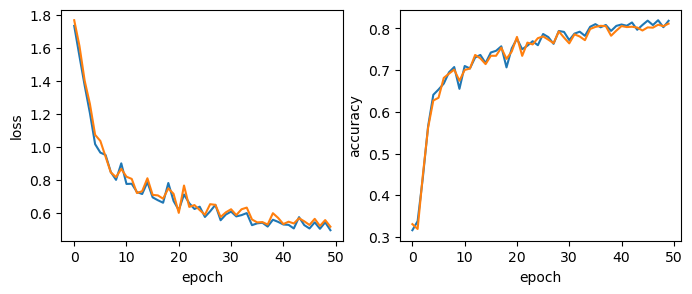

In [17]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(training_loss_vs_epoch,label='training')
ax[0].plot(validation_loss_vs_epoch,label='validation')

ax[1].plot(training_acc_vs_epoch)
ax[1].plot(validation_acc_vs_epoch)

ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')
for i in range(2):
    ax[i].set_xlabel('epoch')
plt.show()